# Looking up a linear type in a provenance graph

In [1]:
from pathlib import Path
import pickle

import pandas as pd
from prov.model import ProvDocument
from prov.graph import prov_to_graph, graph_to_prov

from flatprovenancetypes import print_flat_type, calculate_flat_provenance_types

In [2]:
# point this path to where the provenance graphs are
graphs_path = Path("../datasets/CM-Routes/")
# point this path to where it can find the kernels' ".picked" files
kernels_path = Path("../outputs/CM-Routes/kernels/")

In [3]:
# the kernel we want to work with
kernel_id = "FA_2"

## Load a feature table

In [4]:
kernel_file_path = kernels_path / (kernel_id + ".pickled")
features_df = pd.read_pickle(kernel_file_path)

In [5]:
features_df.head()

Number,FA2_1,FA2_2,FA2_3,FA2_4,FA2_5,FA2_6,FA2_7,FA2_8,FA2_9,FA2_10,FA2_11,FA2_12,FA2_13,FA2_14,FA2_15,FA2_16,FA2_17,FA2_18,FA2_19,FA2_20
graph_file,,,,,,,,,,,,,,,,,,,,
Route51922.0.json,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Route59585.0.json,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Route39208.0.json,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Route42721.0.json,10,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Route58205.0.json,3,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Load type map for the selected kernel

In [6]:
types_map_filepath = kernels_path / (kernel_id + "_types_map.pickled")
with types_map_filepath.open("rb") as f:
    types_map = pickle.load(f)

In [7]:
prov_type = types_map["FA2_1"]
prov_type

(frozenset({<QualifiedName: collabmap:Route>,
            <QualifiedName: collabmap:RouteSet>,
            <QualifiedName: prov:Entity>}),
 frozenset({<QualifiedName: prov:Derivation>, <QualifiedName: prov:Usage>}),
 frozenset({<QualifiedName: prov:Derivation>,
            <QualifiedName: prov:Generation>}))

In [8]:
# to see the pretty-formatted string
print_flat_type(prov_type)

'[der|gen]→[der|usd]→[ent|collabmap:Route|collabmap:RouteSet]'

## Load a provenance graph

In [9]:
graph_filename = "Route51922.0.json"
prov_doc = ProvDocument.deserialize(graphs_path / graph_filename)

In [10]:
# converting the PROV document into a NetworkX graph
# see https://networkx.org/documentation/stable/reference/classes/multidigraph.html
prov_graph = prov_to_graph(prov_doc)

In [11]:
# a view of all the nodes
prov_graph.nodes

NodeView((<ProvEntity: UpVote56562.0>, <ProvEntity: RouteSet9241.1>, <ProvEntity: UpVote56563.0>, <ProvEntity: UpVote51924.0>, <ProvEntity: Route51922.0>, <ProvActivity: CompletionVerification36641>, <ProvActivity: RouteVerification36640>))

## Construct linear types in the graph

In [12]:
fptypes = calculate_flat_provenance_types(
    prov_doc,  # the ProvDocument object to produce types from
    to_level=2,  # calculate types up to this given level (2)
    including_primitives_types=True,  # also consider application-specific types
)

In [13]:
fptypes.keys()  # all the available levels

dict_keys([0, 1, 2])

In [14]:
# Looking for prov_type in fptypes
for qn, t2 in fptypes[2].items():
    if t2 == prov_type:
        print(qn)
        # stop at the first find
        break

UpVote56563.0


## Extract a sub-graph at a given node

In [15]:
# get the element from the identifier
node = prov_doc.get_record(qn)[0]

In [16]:
# find all the successors of node
successors = prov_graph.successors(node)

In [17]:
list(successors)

[<ProvEntity: RouteSet9241.1>, <ProvActivity: CompletionVerification36641>]

In [18]:
def successors_at_level(graph, node, level):
    results = set()
    nodes_to_visit = {node}
    for _ in range(level):
        successors = set()
        while nodes_to_visit:
            n = nodes_to_visit.pop()
            successors.update(graph.successors(n))
            results.add(n)
        nodes_to_visit = successors

    # put all nodes in the last layer to results
    results.update(nodes_to_visit)
    return results

In [19]:
successors_at_level(prov_graph, node, 2)

{<ProvActivity: CompletionVerification36641>,
 <ProvEntity: Route51922.0>,
 <ProvEntity: RouteSet9241.1>,
 <ProvEntity: UpVote56563.0>}

In [20]:
# produce a subgraph of node with level away
def produce_sub_graph(graph, node, level: int):
    nodes = successors_at_level(graph, node, level)
    return prov_graph.subgraph(nodes)

### Convert a subgraph back to a PROV document

In [21]:
subgraph_of_node = produce_sub_graph(prov_graph, node, 2)
prov_doc_of_node = graph_to_prov(subgraph_of_node)

In [22]:
print(prov_doc_of_node.get_provn())

document
  default <http://www.collabmap.org/data/local/20140716/>
  prefix collabmap <http://www.orchid.ac.uk/ontologies/collabmap.owl#>
  
  entity(RouteSet9241.1, [prov:type='collabmap:RouteSet'])
  entity(UpVote56563.0, [prov:type='collabmap:Vote', prov:value=1])
  entity(Route51922.0, [prov:type='collabmap:Route'])
  activity(CompletionVerification36641, 2012-02-23T22:57:28, 2012-02-23T22:57:32, [prov:type='collabmap:CompletionVerification'])
  wasDerivedFrom(RouteSet9241.1, Route51922.0, -, -, -, [prov:type='collabmap:includes'])
  wasDerivedFrom(UpVote56563.0, RouteSet9241.1, -, -, -, [prov:type='collabmap:votedOn'])
  wasGeneratedBy(UpVote56563.0, CompletionVerification36641, 2012-02-23T22:57:32)
  used(CompletionVerification36641, RouteSet9241.1, 2012-02-23T22:57:28)
endDocument


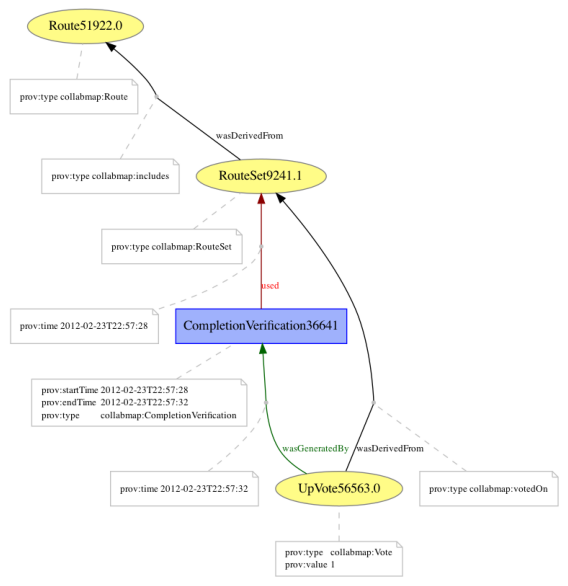

In [23]:
prov_doc_of_node.plot()